# A/B Testing: Impact of Campaign Frequency on Deposit Account Openings + Business Recommendation

- **Experiment Name:** A/B Testing to Increase Deposit Account Openings Through Campaign Frequency.  
- **Hypothesis Definition:**  
  - **H0:** The number of campaigns does not influence users' willingness to open a deposit account.  
  - **H1:** The number of campaigns increases users' willingness to open a deposit account.  
- **Participants:** Bank customers.  
- **Tested Variables:**  
  - **Independent variable:** Number of campaigns received by customers.  
  - **Dependent variable:** Whether the customer opens a deposit account (`y`).  
- **Key Metric:** p-value.  
- **Output:** Business Recommendation (Scroll down to read the business recommendation.)

## Read data

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')

df_bank = pd.read_csv('bank.csv', sep=';')
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Making sure that there's no duplicated data

In [2]:
df_bank.duplicated().sum()

0

## Data distribution

(0.0, 10.0)

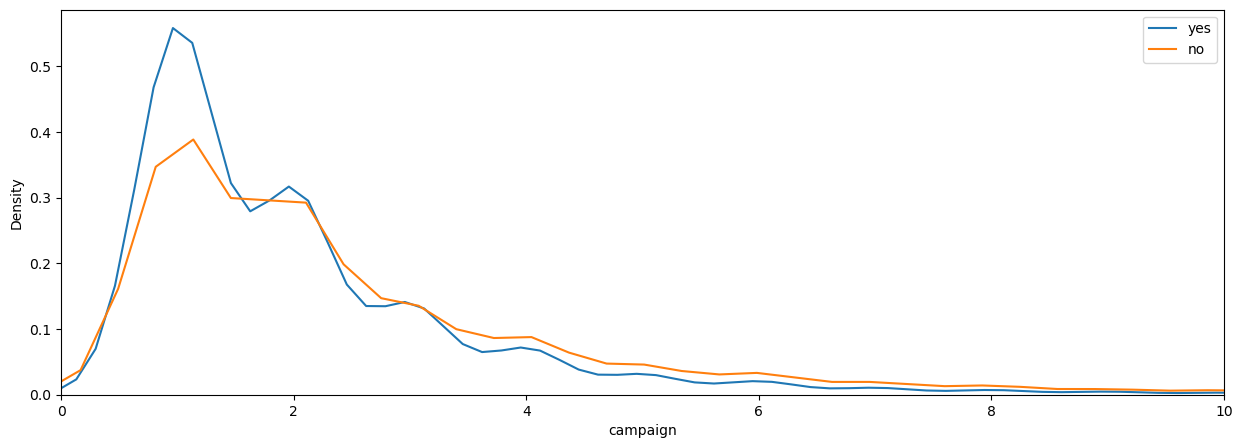

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

yes = df_bank[df_bank['y']=='yes']
no = df_bank[df_bank['y']=='no']

plt.figure(figsize=(15,5))

sns.kdeplot(yes['campaign'],label = 'yes')
sns.kdeplot(no['campaign'], label = 'no')

plt.legend()
plt.xlim(0,10)

## Assumption Testing

In [3]:
import statsmodels.api as sm
import numpy as np

X = df_bank[['campaign']] 
X = sm.add_constant(X) # add constant
y = df_bank['y'].apply(lambda x: 1 if x == 'yes' else 0)

model = sm.Logit(y, X)
result = model.fit()

pvalue_asumsi = float(result.pvalues['campaign'])
print(f"p-value for assumption test: {pvalue_asumsi}")

Optimization terminated successfully.
         Current function value: 0.357001
         Iterations 7
p-value for assumption test: 2.1470244580500214e-56


### Why we need constant?

The logistic regression model is:  

$$ \text{logit}(y) = \beta_0 + \beta_1 \times \text{campaign} $$  

- Without a constant:  
  - The model only considers `campaign` as a predictor.  
  - If `campaign = 0`, it assumes the probability of opening an account is 50%, which may not be always true.  

- With a constant:  
  - The model accounts for a baseline probability even when no campaign is conducted.  
  - This makes the model more flexible and realistic.  

In [4]:
if pvalue_asumsi <= 0.05:
    print("Linearity assumption in logit is met (p-value campaign < 0.05).")
else:
    print("Linearity assumption in logit is not met (p-value campaign >= 0.05).")

Linearity assumption in logit is met (p-value campaign < 0.05).


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variabel independen dalam model logit
X = df_sample[['campaign']]
X = sm.add_constant(X)  

# Menghitung VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

# Check for multicollinearity
threshold = 10  # Standard threshold for high multicollinearity
high_vif = vif_data[vif_data["VIF"] > threshold]

if not high_vif.empty:
    print("High multicollinearity detected:")
    print(high_vif)
    print("Consider removing or transforming the variable(s) above.")
else:
    print("No significant multicollinearity detected. The model variables are stable.")


Variance Inflation Factor (VIF):
   Variable       VIF
0     const  2.195649
1  campaign  1.000000
No significant multicollinearity detected. The model variables are stable.


**Assumption Testing & Handling:**  
- The p-value confirms that the linearity assumption in logit is met. 
- There is no significant multicollinearity based on VIF values.

**Conclussion**:

Logistic regression is an appropriate method for hypothesis testing.  

## Hypothesis Testing  

- **Hypothesis Formulation:**  
  - **H0:** The number of campaigns does not influence users' willingness to open a deposit account.  
  - **H1:** The number of campaigns increases users' willingness to open a deposit account.  


## Step 1: Determine Sample Size and Draw a Sample Using Slovin's Formula

To determine the required sample size, **Slovin's formula** is used:  

$$n = \frac{N}{1 + N e^2}$$

where:  
- **N** = Population size (total number of rows in `df_bank`).  
- **e** = Margin of error (set to **5% or 0.05**).  
- **n** = Required sample size.  

In [ ]:
N = len(df_bank)  # population size
e = 0.05  # 5% error rate

n = N / (1 + N * e**2)
n = int(n)
print(f"Sample size based on Slovin's formula: {n}")

Sample size based on Slovin's formula: 396


In [6]:
campaign_counts = df_bank['campaign'].value_counts(normalize=True)
campaign_sample_sizes = (campaign_counts * n).round().astype(int)

df_sample = df_bank.groupby('campaign', group_keys=False).apply(
    lambda x: x.sample(n=campaign_sample_sizes.loc[x.name], random_state=42)
)

df_sample

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
111,46,technician,divorced,secondary,no,79,no,no,unknown,5,may,144,1,-1,0,unknown,no
37757,28,management,single,tertiary,no,1027,yes,no,cellular,14,may,433,1,-1,0,unknown,no
25073,37,management,married,primary,no,5427,no,no,cellular,18,nov,201,1,159,1,failure,no
3261,42,blue-collar,single,secondary,no,1306,yes,no,unknown,15,may,265,1,-1,0,unknown,no
15096,30,management,married,tertiary,no,248,no,no,cellular,17,jul,692,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,33,housemaid,married,secondary,no,0,yes,yes,cellular,23,jul,85,13,-1,0,unknown,no
16698,47,self-employed,married,tertiary,no,751,no,no,cellular,24,jul,408,14,-1,0,unknown,no
23627,31,housemaid,married,tertiary,no,0,no,no,unknown,28,aug,12,15,-1,0,unknown,no
16922,31,management,married,tertiary,no,430,yes,no,cellular,25,jul,137,16,-1,0,unknown,no


### Campaign Distribution Comparison: Original vs Sample  
To ensure the sampled data maintains a similar distribution as the original dataset, let's compare the campaign frequency distribution before and after sampling. Since the original and sampled datasets may have different sizes, using percentage instead of absolute counts allows for a fair comparison.  

The bar chart below compares the proportion of `campaign` values in the original dataset and the sampled dataset.

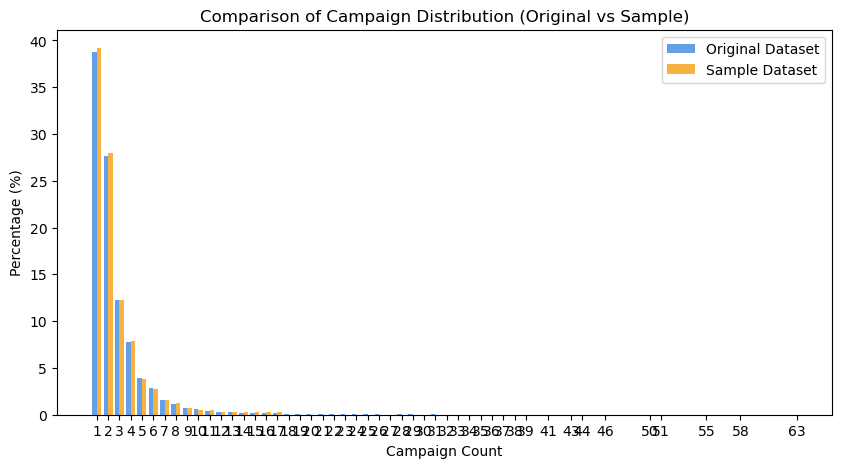

In [7]:
import matplotlib.pyplot as plt

total_original = len(df_bank)
total_sample = len(df_sample)

campaign_dist_original = (df_bank['campaign'].value_counts() / total_original) * 100
campaign_dist_sample = (df_sample['campaign'].value_counts() / total_sample) * 100

plt.figure(figsize=(10,5))

plt.bar(campaign_dist_original.index - 0.2, campaign_dist_original.values, width=0.4, 
        label="Original Dataset", alpha=0.85, color='#4a90e2')
plt.bar(campaign_dist_sample.index + 0.2, campaign_dist_sample.values, width=0.4, 
        label="Sample Dataset", alpha=0.85, color='#f5a623')

plt.xlabel("Campaign Count")
plt.ylabel("Percentage (%)")
plt.title("Comparison of Campaign Distribution (Original vs Sample)")
plt.xticks(sorted(df_bank['campaign'].unique()))
plt.legend()
plt.show()

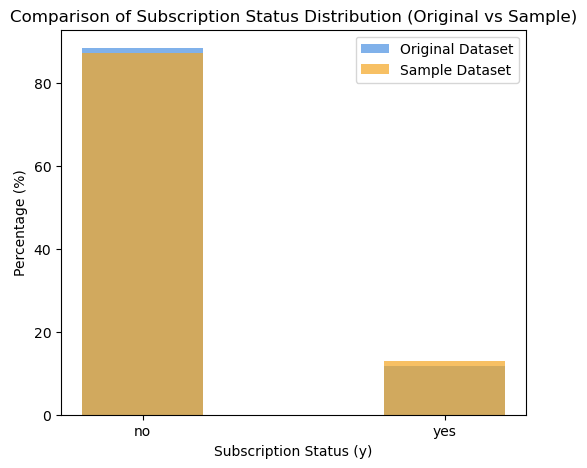

In [8]:
import matplotlib.pyplot as plt

total_original = len(df_bank)
total_sample = len(df_sample)

y_dist_original = (df_bank['y'].value_counts() / total_original) * 100
y_dist_sample = (df_sample['y'].value_counts() / total_sample) * 100

plt.figure(figsize=(6,5))

plt.bar(y_dist_original.index, y_dist_original.values, width=0.4, label="Original Dataset", alpha=0.7, color='#4a90e2')
plt.bar(y_dist_sample.index, y_dist_sample.values, width=0.4, label="Sample Dataset", alpha=0.7, color='#f5a623')

plt.xlabel("Subscription Status (y)")
plt.ylabel("Percentage (%)")
plt.title("Comparison of Subscription Status Distribution (Original vs Sample)")
plt.xticks(['no', 'yes'])
plt.legend()
plt.show()

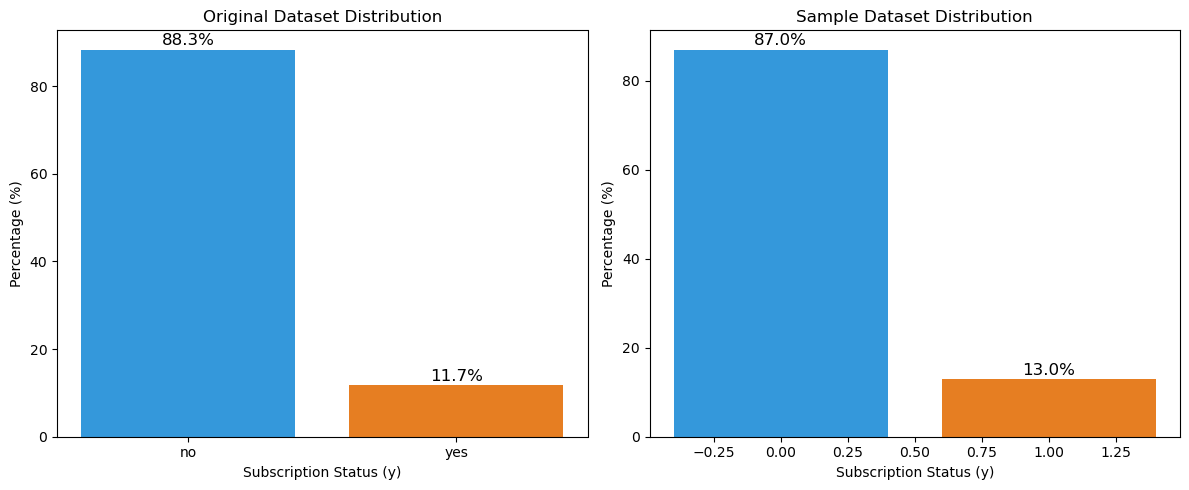

In [26]:

df_bank_y_counts = df_bank['y'].value_counts(normalize=True) * 100
df_sample_y_counts = df_sample['y'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(df_bank_y_counts.index, df_bank_y_counts.values, color=['#3498db', '#e67e22'])
axes[0].set_title("Original Dataset Distribution")
axes[0].set_xlabel("Subscription Status (y)")
axes[0].set_ylabel("Percentage (%)")

for i, v in enumerate(df_bank_y_counts.values):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

axes[1].bar(df_sample_y_counts.index, df_sample_y_counts.values, color=['#3498db', '#e67e22'])
axes[1].set_title("Sample Dataset Distribution")
axes[1].set_xlabel("Subscription Status (y)")
axes[1].set_ylabel("Percentage (%)")

for i, v in enumerate(df_sample_y_counts.values):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

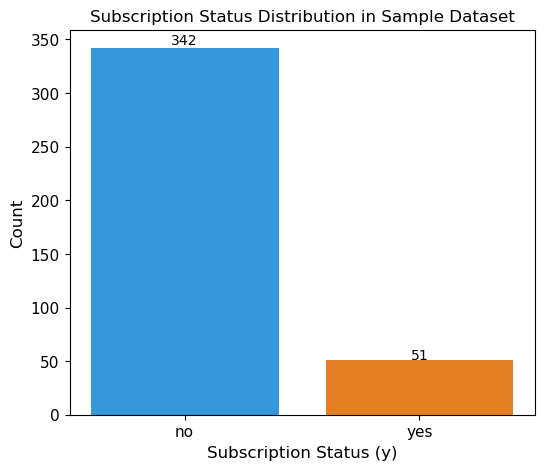

In [9]:
import matplotlib.pyplot as plt

y_counts = df_sample['y'].value_counts()

plt.figure(figsize=(6,5))
bars = plt.bar(y_counts.index, y_counts.values, color=['#3498db', '#e67e22'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             yval * 1.01,
             f"{int(yval)}", 
             ha='center')

# Labeling
plt.xlabel("Subscription Status (y)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Subscription Status Distribution in Sample Dataset")
plt.xticks(['no', 'yes'], fontsize=11)
plt.yticks(fontsize=11)

plt.show()

From the charts, we can confirm that the data distribution of original and sample are quite the same. Hence, we can move to the next step.

## Step 2: Pre-processing; Change target to integer
(yes = 1, no = 0)

In [10]:
df_sample['y'] = df_sample['y'].apply(lambda x: 1 if x == 'yes' else 0)

## Step 3: Modeling Using Logistic Regression and Extracting P-Value

### Getting p-value

In [11]:
X = df_sample[['campaign']]
X = sm.add_constant(X)
y = df_sample['y']

In [12]:
model = sm.Logit(y, X)
result = model.fit()
p_value = result.pvalues['campaign']
print(result.summary())
print("P-value: {:.30f}".format(p_value))

Optimization terminated successfully.
         Current function value: 0.384171
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  393
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.004613
Time:                        20:36:48   Log-Likelihood:                -150.98
converged:                       True   LL-Null:                       -151.68
Covariance Type:            nonrobust   LLR p-value:                    0.2368
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6928      0.235     -7.215      0.000      -2.153      -1.233
campaign      -0.0863      0.

In [13]:
if p_value >= 0.05:
    print("Accept H0; meaning there is not enough evidence that the number of campaigns affects users' willingness to open a deposit account.")
else:
    print("Accept H1; meaning there is sufficient evidence that the number of campaigns increases users' willingness to open a deposit account.")

Accept H0; meaning there is not enough evidence that the number of campaigns affects users' willingness to open a deposit account.


### Calculating Odds Ratio

The **odds ratio (OR)** measures how a predictor variable (in this case, `campaign`) affects the likelihood of an event occurring (customers opening a deposit account). It is calculated as:  

$$
\text{Odds Ratio} = e^{\beta}
$$

where **$\beta$** is the coefficient of `campaign` from the logistic regression model.

In [14]:
odds_ratio = np.exp(result.params['campaign'])
print(f"Odds Ratio for campaign: {odds_ratio:.4f}")
if odds_ratio > 1:
    print("OR > 1: The higher the number of campaigns, the greater the likelihood that customers will open a deposit account.")
elif odds_ratio < 1:
    print("OR < 1: The higher the number of campaigns, the lower the likelihood that customers will open a deposit account.")
else:
    print("OR = 1: The number of campaigns has no effect on the likelihood of customers opening a deposit account.")


Odds Ratio for campaign: 0.9173
OR < 1: The higher the number of campaigns, the lower the likelihood that customers will open a deposit account.


### Quadratic Term

In [15]:
import statsmodels.api as sm

# Create quadratic term for campaign
df_sample['campaign_squared'] = df_sample['campaign'] ** 2

X = sm.add_constant(df_sample[['campaign', 'campaign_squared']])
y = df_sample['y']

# Fit logistic regression model with quadratic term
model_quad = sm.Logit(y, X)
result_quad = model_quad.fit()

print(result_quad.summary())

coef_campaign_squared = result_quad.params['campaign_squared']
pval_campaign_squared = result_quad.pvalues['campaign_squared']

if coef_campaign_squared < 0 and pval_campaign_squared < 0.05:
    print("\nThe coefficient of campaign_squared is negative and statistically significant (p < 0.05).")
    print("This suggests that there are diminishing returns: after a certain number of campaigns,\nadditional campaigns may have a decreasing effect on the likelihood of opening a deposit account.")
else:
    print("\nThe coefficient of campaign_squared is not significantly negative.")
    print("There is no evidence that additional campaigns become less effective,\nso the business/marketing team can consider increasing campaign frequency to drive more deposit account openings.")


Optimization terminated successfully.
         Current function value: 0.384132
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  393
Model:                          Logit   Df Residuals:                      390
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.004712
Time:                        20:36:48   Log-Likelihood:                -150.96
converged:                       True   LL-Null:                       -151.68
Covariance Type:            nonrobust   LLR p-value:                    0.4893
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.7360      0.344     -5.041      0.000      -2.411      -1.061
campaign   

## Business Recommendations  

### Key Findings  
1. There is no strong evidence that the number of campaigns significantly influences users' willingness to open a deposit account.  
2. If there is any effect, it is slightly negative; more campaigns may actually decrease the likelihood of customers opening a deposit account.  
3. However, there is no clear diminishing returns effect, meaning that adding more campaigns does not make the situation worse over time, but it also does not improve it.  

### Business/Marketing Recommendations  
#### 1. Do not increase campaign frequency without strategy  
Since there is no strong evidence that campaigns have a positive impact, the business should stop increasing campaign numbers blindly and focus on improving quality.  

#### 2. Investigate why more campaigns may slightly reduce conversions  
More campaigns might annoy customers or feel irrelevant. The marketing team should test whether customers feel overwhelmed and adjust the campaign approach accordingly.  

#### 3. Focus on precision rather than frequency  
Instead of increasing campaigns for all customers, use data-driven targeting to send fewer but more effective campaigns to the right audience.  

#### 4. Test alternative engagement methods  
Since more campaigns do not necessarily help or harm, try other approaches such as emails, in-app notifications, or personalized offers.